In [6]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold, train_test_split
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import timm
from torchmetrics import Metric
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import random

In [2]:
class NMAE(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("nmae", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        nmae = torch.sum(torch.abs(target-preds) / (torch.abs(target)))
        n_obs = target.numel()
        self.nmae += nmae
        self.total += n_obs
    def compute(self):
        return self.nmae / self.total

In [16]:
preprocessing_train_imgs = glob("D:/DACON_GROWTH/PREPROCESSING-TRAIN_224/*")
preprocessing_test_imgs = glob("D:/DACON_GROWTH/PREPROCESSING-TEST_224/*")
augmetation_imgs = glob("D:/DACON_GROWTH/AUGMENTATION/SIZE224/*")

outlier_imgs = []
outlier_path = []
train_path = []
train_imgs = []
for path in tqdm(preprocessing_train_imgs):
    img_file = os.path.basename(path)
    img_name = img_file.split(".")[0]
    case = img_name.split("_")[0]
    if case in ["CASE59", "CASE11", "CASE12", "CASE13", "CASE14"]:
        continue
    elif img_name in ["CASE05_21", "CASE10_41", "CASE45_16", "CASE45_17",
                     "CASE73_04", "CASE73_10", "CASE73_11", "CASE73_14"]:        
        continue
    elif case in ["CASE16", "CASE22", "CASE23"]:
        continue
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        train_path.append(path)
        train_imgs.append(img)
        
test_path = []
test_imgs = []
for path in tqdm(preprocessing_test_imgs):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    test_path.append(path)
    test_imgs.append(img)

augment_path = []
augment_imgs = []
for path in tqdm(augmetation_imgs):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    augment_path.append(path)
    augment_imgs.append(img)
    
augment_path = augment_path + outlier_path
augment_imgs = augment_imgs + outlier_imgs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 523.72it/s]


In [18]:
validset_path, trainset_path  = train_test_split(train_path, train_size =0.078, shuffle=False)
valid_imgset, train_imgset = train_test_split(train_imgs, train_size =0.078, shuffle=False)

In [127]:
golden_dict["18:05"]

919

In [129]:
main_path = "D:/DACON_GROWTH"
train_data = glob(main_path+"/train/*/meta/*.csv")
train_label = glob(main_path+"/train/*/*.csv")
test_data = glob(main_path+"/test/meta/*.csv")

train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df["이미지"] = name
    case = name.split("_")[0]
    label = pd.read_csv(f"D:/DACON_GROWTH/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    df = df.replace([np.inf, -np.inf], np.nan)
    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df["무게"] = train_df["무게"].apply(lambda x: 0.001 if x<0.001 else x)

img2weight = {}
for i in tqdm(train_df["이미지"].unique()):
    temp = train_df[train_df["이미지"]==i]
    weight = temp["무게"].values[0]
    img2weight[i] = weight
    
train_df["시간2"] = train_df["시간"].apply(lambda x: x.split(" ")[-1])
golden_time = ['17:40', '17:41', '17:42', '17:43', '17:44', '17:45', '17:46', '17:47', '17:48', '17:49', '17:50',
               '17:51', '17:52', '17:53', '17:54', '17:55', '17:56', '17:57', '17:58', '17:59', '18:00', '18:01',
               '18:02', '18:03', '18:04', '18:05']
golden_dict ={}
for e, i in enumerate(train_df["시간2"].unique()):
       golden_dict[i] = e
train_df["순서"] = train_df["시간2"].apply(lambda x : golden_dict[x])

train_df2 = train_df[(train_df["순서"] > 894) & (train_df["순서"] < 919)]

train_dfx = train_df2.copy()
train_dfx.drop(columns=["시간", "시간2"], inplace=True)
train_dfx.fillna(0., inplace=True)

# img2data = {}
# for i in tqdm(train_dfx['이미지'].unique()):
#     temp = train_dfx[train_dfx["이미지"]==i]
#     temp.drop(columns = ["무게", "이미지"], inplace=True)
#     img2data[i] = np.array(temp[["EC관측치",'내부습도관측치', '외부습도관측치']].values, dtype=np.float32)
    
# test_df = []
# for i in tqdm(test_data):
#     name = i.split("\\")[-1].split(".")[0]
#     df = pd.read_csv(i)
#     df["이미지"] = name
#     df = df.replace([np.inf, -np.inf], np.nan)
#     test_df.append(df)
    
# test_df = pd.concat(test_df, ignore_index=True)
# test_df["시간2"] = test_df["시간"].apply(lambda x: x.split(" ")[-1])
# test_df["순서"] = test_df["시간2"].apply(lambda x : golden_dict[x])
# test_df2 = test_df[(test_df["순서"] > 894) & (test_df["순서"] < 919)]

# test_dfx = test_df2.copy()
# test_dfx.drop(columns=["시간", "시간2"], inplace=True)
# test_dfx.fillna(0., inplace=True)

# img2test = {}
# for i in tqdm(test_dfx['이미지'].unique()):
#     temp = test_dfx[test_dfx["이미지"]==i]
#     temp.drop(columns = "이미지", inplace=True)
#     img2test[i] = np.array(temp[["EC관측치",'내부습도관측치', '외부습도관측치']].values, dtype=np.float32)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1592/1592 [00:22<00:00, 69.90it/s]


In [130]:
features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']
train_feature = train_dfx[features]
train_weight = train_dfx["무게"]

In [131]:
train_feature.shape

(38208, 18)

In [138]:
class DNN_DATASET(nn.Module):
    def __init__(self, x, y):
        super(DNN_DATASET, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        out = self.x[idx]
        target = self.y[idx]

        return out, target
    
train_set = DNN_DATASET(train_feature.values, train_weight.values)
train_loader = DataLoader(train_set, shuffle=True, batch_size=16, num_workers=0)

In [141]:
class Linear_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(18, 2)
        self.out = nn.Linear(2, 1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.out(x)
        return x
        

In [142]:
model = Linear_model().cuda()
Epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()
device = 'cuda'
for epoch in range(Epoch):
    train_loss = 0.
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch[0]
        y = batch[1]
        x = x.float().to(device)
        y = y.float().to(device)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_loader)

    print(f'TRAIN    loss : {train_loss:.5f} epoch : {epoch} ')

D:\meta2\venv\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


TRAIN    loss : 73.77092 epoch : 0 
TRAIN    loss : 72.36902 epoch : 1 
TRAIN    loss : 72.14285 epoch : 2 
TRAIN    loss : 71.98526 epoch : 3 
TRAIN    loss : 71.86070 epoch : 4 
TRAIN    loss : 71.77276 epoch : 5 
TRAIN    loss : 71.69546 epoch : 6 
TRAIN    loss : 71.62692 epoch : 7 
TRAIN    loss : 71.54614 epoch : 8 
TRAIN    loss : 71.47409 epoch : 9 
TRAIN    loss : 71.43765 epoch : 10 
TRAIN    loss : 71.38789 epoch : 11 
TRAIN    loss : 71.36752 epoch : 12 
TRAIN    loss : 71.29125 epoch : 13 
TRAIN    loss : 71.23389 epoch : 14 
TRAIN    loss : 71.25303 epoch : 15 
TRAIN    loss : 71.20638 epoch : 16 
TRAIN    loss : 71.18149 epoch : 17 
TRAIN    loss : 71.14258 epoch : 18 
TRAIN    loss : 71.16387 epoch : 19 
TRAIN    loss : 71.14109 epoch : 20 
TRAIN    loss : 71.15353 epoch : 21 
TRAIN    loss : 71.10092 epoch : 22 
TRAIN    loss : 71.09323 epoch : 23 
TRAIN    loss : 71.10407 epoch : 24 
TRAIN    loss : 71.07934 epoch : 25 
TRAIN    loss : 71.05545 epoch : 26 
TRAIN    lo

KeyboardInterrupt: 

In [107]:
temp = train_df[train_dfㅌ["외부온도관측치"]!=0]
temp.reset_index(drop=True)

In [106]:
test_df["CO2관측치"]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
662395    0.022596
662396    0.022596
662397    0.023349
662398    0.022596
662399    0.021843
Name: EC관측치, Length: 662400, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

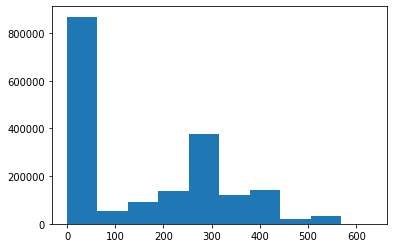

In [124]:
import matplotlib.pyplot as plt
plt.hist(train_df["총추정광량"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

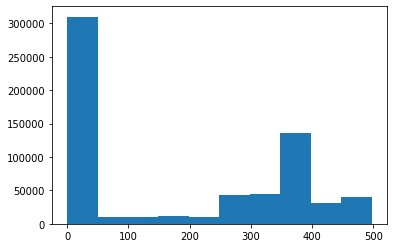

In [125]:
plt.hist(test_df["총추정광량"])
plt.show

In [53]:
class PYTORCH_DATASET(nn.Module):
    def __init__(self, path: list, img2weight: dict, imgs: np.array, img2data: dict,  \
                 transform=None):
        super(PYTORCH_DATASET, self).__init__()
        self.path = path
        self.imgs = imgs

        self.transform = transform
        self.img2weight = img2weight
        self.img2data = img2data

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        before_img = self.imgs[idx]
        img_path = self.path[idx]
        img_path = img_path.split("\\")[-1].split(".")[0]
        df_index = self.img2data[img_path]
        df_label = self.img2weight[img_path]

        after_img = self.transform(image=before_img)["image"]

        return {"사진": after_img, "정보": df_index, "상표": df_label}


class PYTORCH_PREDICTSET(nn.Module):
    def __init__(self, path: list,  imgs: np.array, img2data: dict, \
                 transform=None):
        super(PYTORCH_PREDICTSET, self).__init__()
        self.path = path
        self.imgs = imgs

        self.transform = transform
        self.img2data = img2data

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        before_img = self.imgs[idx]
        img_path = self.path[idx]
        img_path = img_path.split("\\")[-1].split(".")[0]
        df_index = self.img2data[img_path]
        after_img = self.transform(image=before_img)["image"]
        return {"사진": after_img, "정보": df_index}

class PYTORCH_AUGMENTSET(nn.Module):
    def __init__(self, aug_imgs: np.array, transform_ori = None, transform_aug=None):
        super(PYTORCH_AUGMENTSET, self).__init__()
        self.aug_imgs = aug_imgs
        self.transform_ori = transform_ori
        self.transform_aug = transform_aug

    def __len__(self):
        return len(self.aug_imgs)

    def __getitem__(self, idx):
        before_img = self.aug_imgs[idx]
        after_img = self.transform_aug(image=before_img)["image"]
        before_img = self.transform_ori(image=before_img)["image"]
        temp_data = torch.FloatTensor(torch.zeros([49, 3]))

        return {"원본": before_img, "확장": after_img, "정보": temp_data}

In [54]:
image_size = 224

train_mode= albu.Compose([
    albu.RandomResizedCrop(height=image_size, width=image_size,
                           scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333),
                           interpolation=1, p=0.9),
    albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                          rotate_limit=30, interpolation=1, border_mode=0, value=0, p=0.25),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([
        albu.MotionBlur(p=.2),
        albu.MedianBlur(blur_limit=3, p=0.1),
        albu.Blur(blur_limit=3, p=0.1),
        albu.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.4,p=0.2)
    ], p=0.25),
    albu.OneOf([
        albu.CLAHE(clip_limit=2),
        albu.Sharpen(),
        albu.Emboss(),
        albu.RandomBrightnessContrast(),
    ], p=0.25),
    albu.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.25),
    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

test_mode = albu.Compose([
    #                 albu.Resize(self.image_size, self.image_size),
    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

import torch
import numpy as np
from torch import nn
from einops.layers.torch import Rearrange


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MixerBlock(nn.Module):

    def __init__(self, dim, num_sequence, token_dim, channel_dim, dropout=0.):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_sequence, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, channel_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channel_dim, dim),
            nn.Dropout(dropout)
            
        )

    def forward(self, x):
        x = x + self.token_mix(x)

        x = self.channel_mix(x)

        return x

class MLPMixer(nn.Module):

    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout
        self.dim = 3
        self.num_sequence = 49
        self.token_dim = 64
        self.channel_dim = 16
        self.mixer_blocks = nn.ModuleList([])
        self.depth = 1
        for _ in range(self.depth):
            self.mixer_blocks.append(MixerBlock(self.dim, self.num_sequence, self.token_dim, self.channel_dim, self.dropout))
        self.layer_norm = nn.LayerNorm(self.dim)

    def forward(self, x):
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)

        x = x.mean(dim=1)

        return x
    
class CNN_MIXER(nn.Module):
    def __init__(self):
        super(CNN_MIXER, self).__init__()
        self.model = timm.create_model("efficientnet_b0", pretrained=True, \
                                       num_classes=1)
        self.meta = MLPMixer(0.3)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1283, 256)
        self.output = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.9)
        self.dropout1 = nn.Dropout(0.65)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0)

    def forward(self,  x, x2, training):
        x = self.model.forward_features(x)
        x = self.avg(x)
        x = x.flatten()
        x = x.view(-1,  1280)
        x = self.dropout(x)
        x2 = self.meta(x2)
        if training:
            c = random.choice([0, 0, 0, 1, 2, 3])
            if c == 0:
                pass
            elif c == 1:
                x2 = self.dropout1(x2)
            elif c == 2:
                x2 = self.dropout2(x2)
            elif c == 3:
                x2 = self.dropout3(x2)
        x = torch.cat([x, x2], dim=-1)
        x = self.linear(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [55]:
from pytorch_lightning.trainer.supporters import CombinedLoader

class LIGHTNING_MODEL(pl.LightningModule):
    def __init__(self, model, train_datasest, val_dataset, augment_dataset, predict_dataset):
        super(LIGHTNING_MODEL, self).__init__()
        self.model = model()
        self.train_nmae = NMAE()
        self.valid_nmae = NMAE()
        self.augment_dataset= augment_dataset
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.predict_dataset = predict_dataset
        self.bestnmae = 10.
        
    def forward(self, x):
        output = self.model(x)
        return output
    
    def train_dataloader(self):
        loaders = {"a": DataLoader(self.train_dataset, shuffle=True, batch_size=32, num_workers=0), \
                   "b": DataLoader(self.augment_dataset, shuffle=True, batch_size=8, num_workers=0)}
        combined_loaders = CombinedLoader(loaders, mode="max_size_cycle")
        return combined_loaders
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=False, batch_size=32, num_workers=0)
    
    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, shuffle=False, batch_size=32, num_workers=0)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        ori_batch = train_batch["a"]
        aug_batch = train_batch["b"]
        img = ori_batch["사진"]
        data = ori_batch["정보"]
        label = ori_batch["상표"]
        
        ori = aug_batch["원본"]
        ext = aug_batch["확장"]
        temp_data = aug_batch["정보"]

        pred = self.model(img, data, training=True)
        pred = pred.view(-1)
        label = label.view(-1)
        
        train_loss = nn.L1Loss()(pred, label)
        self.log("train_loss", train_loss)
        
        train_nmae = self.train_nmae(pred, label)
        self.log('train_NMAE', train_nmae)
        
        with torch.no_grad():
            ori_out = self.model(ori, temp_data, training=False)
            ext_out = self.model(ext, temp_data, training=False)
        con_loss = nn.L1Loss()(ori_out, ext_out)
        con_loss = 0.25 * con_loss 
        self.log('con_loss', con_loss)
        loss = train_loss + con_loss
        self.log('loss', loss)
        return train_loss

    def training_epoch_end(self, outputs):
        train_nmae = self.train_nmae.compute()
        self.log("epoch_train_nmae", train_nmae)
        self.train_nmae.reset()
        print(f"training nmae: {train_nmae:.4}, epoch: {self.trainer.current_epoch}")
        
        
    def validation_step(self, val_batch, batch_idx):
        img = val_batch["사진"]
        data = val_batch["정보"]
        label = val_batch["상표"]

        pred = self.model(img, data, training=False)
        pred = pred.view(-1)
        label = label.view(-1)
        loss = nn.L1Loss()(pred, label)
        self.log("val_loss", loss)
        self.valid_nmae.update(pred, label)
        return loss

    def validation_epoch_end(self, outputs):
        val_nmae = self.valid_nmae.compute()
        self.log("val_nmae", val_nmae)
        ext = val_nmae.item()
        if ext < self.bestnmae:
            self.bestnmae = ext
        self.valid_nmae.reset()
        print(f"validation nmae: {val_nmae:.4}")

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        img = batch["사진"]
        data = batch["정보"]
        pred = self.model(img, data, training=False).unsqueeze(0)
        return pred


In [56]:
train_dataset = PYTORCH_DATASET(path=trainset_path, img2weight=img2weight, imgs=train_imgset, img2data=img2data,\
                                            transform=train_mode)

valid_dataset = PYTORCH_DATASET(path=validset_path, img2weight=img2weight, imgs=valid_imgset, img2data=img2data,\
                                transform=test_mode)

augment_dataset = PYTORCH_AUGMENTSET(aug_imgs=augment_imgs, transform_ori=test_mode, transform_aug=train_mode)

test_dataset = PYTORCH_PREDICTSET(path=test_path, imgs=test_imgs, img2data=img2test, \
                        transform=test_mode)

In [57]:
model_name = "efficientnet_B0"

model = LIGHTNING_MODEL(CNN_MIXER, train_dataset, valid_dataset, augment_dataset, test_dataset)

check_path =  f"D:/DACON_GROWTH/변수체크1/{model_name}"
if not os.path.exists(check_path):
    os.makedirs(check_path)
checkpoint_callback = ModelCheckpoint(dirpath=check_path, save_top_k=1, monitor="val_nmae", \
                                      save_weights_only=True)

trainer = pl.Trainer(
    devices=[0],
    accelerator='gpu',
    max_epochs=50,
    callbacks=[checkpoint_callback],
    precision=16
)

trainer.fit(model)

bestscore = model.bestnmae
checkpoint_ = os.listdir(check_path)[0]
file_name = os.path.basename(checkpoint_).split(".ckpt")[0]
src = os.path.join(check_path, checkpoint_)
score_name = file_name + f"_{bestscore : .4f}.ckpt"
dst = os.path.join(check_path, score_name)
os.rename(src, dst)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | model           | CNN_MIXER          | 4.3 M 
1 | train_nmae      | NMAE               | 0     
2 | valid_nmae      | NMAE               | 0     
3 | augment_dataset | PYTORCH_AUGMENTSET | 0     
4 | train_dataset   | PYTORCH_DATASET    | 0     
5 | val_dataset     | PYTORCH_DATASET    | 0     
6 | predict_dataset | PYTORCH_PREDICTSET | 0     
-------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
8.689     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

validation nmae: 1.001


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation nmae: 1.333
training nmae: 12.14, epoch: 0


Validation: 0it [00:00, ?it/s]

validation nmae: 0.7888
training nmae: 40.01, epoch: 1


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3759
training nmae: 26.98, epoch: 2


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2738
training nmae: 15.72, epoch: 3


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2884
training nmae: 9.61, epoch: 4


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3896
training nmae: 14.84, epoch: 5


Validation: 0it [00:00, ?it/s]

validation nmae: 0.23
training nmae: 9.631, epoch: 6


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2671
training nmae: 20.69, epoch: 7


Validation: 0it [00:00, ?it/s]

validation nmae: 0.4115
training nmae: 10.18, epoch: 8


Validation: 0it [00:00, ?it/s]

validation nmae: 0.376
training nmae: 20.39, epoch: 9


Validation: 0it [00:00, ?it/s]

validation nmae: 0.4867
training nmae: 10.23, epoch: 10


Validation: 0it [00:00, ?it/s]

validation nmae: 0.4008
training nmae: 10.46, epoch: 11


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3707
training nmae: 9.893, epoch: 12


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2357
training nmae: 8.525, epoch: 13


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3516
training nmae: 6.946, epoch: 14


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2698
training nmae: 6.979, epoch: 15


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3735
training nmae: 19.04, epoch: 16


Validation: 0it [00:00, ?it/s]

validation nmae: 0.4011
training nmae: 6.156, epoch: 17


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3748
training nmae: 6.925, epoch: 18


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3607
training nmae: 5.386, epoch: 19


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3174
training nmae: 7.06, epoch: 20


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2475
training nmae: 12.31, epoch: 21


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1848
training nmae: 6.717, epoch: 22


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2042
training nmae: 6.739, epoch: 23


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2245
training nmae: 6.336, epoch: 24


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1646
training nmae: 5.495, epoch: 25


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1871
training nmae: 4.088, epoch: 26


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1805
training nmae: 5.898, epoch: 27


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1949
training nmae: 5.108, epoch: 28


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1991
training nmae: 8.336, epoch: 29


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1623
training nmae: 6.841, epoch: 30


Validation: 0it [00:00, ?it/s]

validation nmae: 0.147
training nmae: 7.125, epoch: 31


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2693
training nmae: 6.592, epoch: 32


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1695
training nmae: 8.131, epoch: 33


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2193
training nmae: 7.631, epoch: 34


Validation: 0it [00:00, ?it/s]

validation nmae: 0.284
training nmae: 9.312, epoch: 35


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3226
training nmae: 7.771, epoch: 36


Validation: 0it [00:00, ?it/s]

validation nmae: 0.6029
training nmae: 11.03, epoch: 37


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1951
training nmae: 6.647, epoch: 38


Validation: 0it [00:00, ?it/s]

validation nmae: 0.5968
training nmae: 6.726, epoch: 39


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3086
training nmae: 8.409, epoch: 40


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2585
training nmae: 6.41, epoch: 41


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2503
training nmae: 6.608, epoch: 42


Validation: 0it [00:00, ?it/s]

validation nmae: 0.3267
training nmae: 9.345, epoch: 43


Validation: 0it [00:00, ?it/s]

validation nmae: 0.4029
training nmae: 4.895, epoch: 44


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1686
training nmae: 4.915, epoch: 45


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2111
training nmae: 7.318, epoch: 46


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2
training nmae: 6.254, epoch: 47


Validation: 0it [00:00, ?it/s]

validation nmae: 0.1689
training nmae: 5.478, epoch: 48


Validation: 0it [00:00, ?it/s]

validation nmae: 0.2035
training nmae: 5.413, epoch: 49


In [58]:
test_dataset = PYTORCH_PREDICTSET(path=test_path, imgs=test_imgs, img2data=img2test, \
                                    transform=test_mode)

model = LIGHTNING_MODEL.load_from_checkpoint(checkpoint_path="D:\DACON_GROWTH\변수체크1\efficientnet_B0/epoch=31-step=1984_ 0.1470.ckpt",
                model=  CNN_MIXER, train_datasest = None, val_dataset = None, \
                augment_dataset= None, predict_dataset = test_dataset)

In [59]:
prediction = trainer.predict(model)
sub_list = []
for p in prediction:
    p = p.view(-1)
    for sample in p:
        sample = sample.cpu().numpy()
        sub_list.append(sample)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\meta2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 62it [00:00, ?it/s]

In [83]:
np.array(sub_list) * 0.87

array([ 54.7   , 274.2   ,   6.48  ,  71.06  ,  79.56  ,  77.4   ,
         1.577 ,  70.56  ,   1.537 ,  80.44  ,   0.644 ,  34.6   ,
        10.49  ,  27.47  ,  11.81  ,  68.75  ,  77.25  ,  27.98  ,
        81.06  , 269.5   ,  32.1   ,   5.492 ,   2.137 ,  14.42  ,
        64.6   ,  73.75  , 128.1   ,  38.47  ,  80.5   ,  84.94  ,
        75.5   ,  15.06  ,   2.525 ,   6.223 ,   8.766 , 148.6   ,
         3.732 ,  78.94  ,   4.434 ,  31.33  ,  81.    , 113.56  ,
         1.781 ,  26.    ,  71.4   ,  25.94  ,  69.25  ,  30.34  ,
        67.94  ,  70.2   , 194.8   ,  65.7   ,  79.75  ,  57.75  ,
        83.94  ,  39.22  ,  78.56  ,  23.84  ,  39.25  ,  72.5   ,
         2.682 ,  34.66  ,  80.6   ,  87.4   ,  77.7   ,  42.53  ,
        73.56  ,  77.7   , 121.4   ,  12.15  , 227.1   ,  85.2   ,
        78.06  ,   2.973 ,  10.53  , 118.7   ,   1.011 ,  69.25  ,
        67.2   ,  70.2   ,  66.8   ,  82.75  ,   8.73  ,  10.18  ,
         2.172 ,  11.836 ,  48.25  ,  57.9   ,  67.94  ,  59.9

In [84]:
sample_submission = pd.read_csv("D:/DACON_GROWTH/sample_submission.csv")
sample_submission["leaf_weight"] = np.array(sub_list) * 0.87
sample_submission.to_csv("D:/DACON_GROWTH/prediction_collection/negative_mixer.csv", index=False)

In [72]:
eff0mixer = pd.read_csv("D:/DACON_GROWTH/prediction_collection/eff03featuremixer.csv")
eff0mixer

,img_name,leaf_weight
0,001.png,67.051250
1,002.png,288.332500
2,003.png,6.248164
3,004.png,73.174375
4,005.png,87.785000
...,...,...
455,456.png,73.720000
456,457.png,87.845625
457,458.png,30.691406
458,459.png,55.987187


In [61]:
def np_nmae(y_true, y_pred):
    result = np.mean(np.abs(y_true-y_pred)) / np.mean(np.abs(y_true))
    return result

In [82]:
np_nmae(best_submission["leaf_weight"], np.array(sub_list)*0.87)

0.07515053752849575

In [81]:
np_nmae(best_submission["leaf_weight"], eff0mixer["leaf_weight"]*0.91)

0.07202574694711976

In [44]:
best_submission = pd.read_csv("D:/DACON_GROWTH/prediction_collection/effV2_eff0_negative_ensemble.csv")
best_submission

,img_name,leaf_weight
0,001.png,56.260000
1,002.png,300.578750
2,003.png,4.577187
3,004.png,67.930312
4,005.png,76.690625
...,...,...
455,456.png,63.929063
456,457.png,77.781875
457,458.png,29.350078
458,459.png,48.681875


In [47]:
sample_submission

,img_name,leaf_weight
0,001.png,67.05125
1,002.png,288.3325
2,003.png,6.248164
3,004.png,73.174375
4,005.png,87.785
...,...,...
455,456.png,73.72
456,457.png,87.845625
457,458.png,30.691406
458,459.png,55.987187


In [48]:
sample_submission.to_csv("D:/DACON_GROWTH/prediction_collection/eff03featuremixer.csv", index=False)